<a href="https://colab.research.google.com/github/steflhermitte/julia-experiments/blob/main/JuliaParallel/Julia_1D_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _1D Diffusion_

<!-- ## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4. -->

# Install Julia GPU in Colab

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [2]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
Environment:
  JULIA_NUM_THREADS = 2


In [3]:
using BenchmarkTools

M = rand(2048, 2048)
@benchmark M^2

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  479.830 ms … 621.322 ms  ┊ GC (min … max): 0.19% … 18.29%
 Time  (median):     499.648 ms               ┊ GC (median):    0.09%
 Time  (mean ± σ):   519.145 ms ±  49.055 ms  ┊ GC (mean ± σ):  4.51% ±  7.06%

  ▁   ▁█▁   █  ▁                                     ▁        ▁  
  █▁▁▁███▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█ ▁
  480 ms           Histogram: frequency by time          621 ms <

 Memory estimate: 32.00 MiB, allocs estimate: 2.

In [4]:
if ENV["COLAB_GPU"] == "1"
    using CUDA

    M_gpu = cu(M)
    @benchmark CUDA.@sync M_gpu^2
else
    println("No GPU found.")
end

BenchmarkTools.Trial: 603 samples with 1 evaluation.
 Range (min … max):  5.924 ms …  10.744 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.293 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.284 ms ± 564.265 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                    ▅█ ▃▁   ▇▂ ▃               
  ▄▁▁▂▁▃▃▂▁▁▁▁▁▂▃▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂██▇██▄▇▄██▅█▆▃▃▄▄▃▁▁▁▁▁▁▃ ▃
  5.92 ms         Histogram: frequency by time        9.49 ms <

 Memory estimate: 208 bytes, allocs estimate: 8.

# 1D Diffusion
From https://github.com/luraess/julia-parallel-course-EGU21/tree/main/scripts

In [6]:
using Plots, Printf, LinearAlgebra

# enable plotting by default
if !@isdefined do_visu; do_visu = true end

true

## Explicit solution

In [20]:
# https://github.com/luraess/julia-parallel-course-EGU21/blob/main/scripts/diffusion_1D_expl.jl

@views function diffusion_1D_expl(; do_visu=true)
    # Physics
    lx     = 10.0        # domain size
    D      = 1.0         # diffusion coefficient
    ttot   = 0.6         # total simulation time
    # Numerics
    nx     = 256         # numerical grid resolution
    # Derived numerics
    dx     = lx/nx       # grid size
    dt     = dx^2/D/2.1  # time step (obeys CFL condition)
    xc     = LinRange(dx/2, lx-dx/2, nx)
    # Array allocation
    qH     = zeros(nx-1) # on staggered grid
    dHdt   = zeros(nx-2) # normal grid, without boundary points
    # Initial condition
    H0     = exp.(-(xc.-lx/2).^2)
    H      = copy(H0)
    t = 0.0; it = 0
    # Physical time loop
    while t<ttot
        qH         .= -D*diff(H)/dx         # flux
        dHdt       .=  -diff(qH)/dx         # rate of change
        H[2:end-1] .= H[2:end-1] .+ dt*dHdt # update rule, sets the BC as H[1]=H[end]=0
        t += dt; it += 1
    end
    # Analytic solution
    Hana = 1/sqrt(4*(ttot+1/4)) * exp.(-(xc.-lx/2).^2 /(4*(ttot+1/4)))
    @printf("Total time = %1.2f, time steps = %d, error vs analytic = %1.2e \n", round(ttot, sigdigits=2), it, norm(H-Hana))
    # Visualize
    if do_visu
        plot(xc, H0, linewidth=3); display(plot!(xc, H, legend=false, framestyle=:box, linewidth=3, xlabel="lx", ylabel="H", title="explicit diffusion (nt=$it)"))
    end
    return xc, H0
end

diffusion_1D_expl (generic function with 1 method)

In [24]:
# https://github.com/luraess/julia-parallel-course-EGU21/blob/main/scripts/diffusion_1D_impl.jl

@views function diffusion_1D_impl(; do_visu=true)
    # Physics
    lx     = 10.0       # domain size
    D      = 1.0        # diffusion coefficient
    ttot   = 0.6        # total simulation time
    dt     = 0.1        # physical time step
    # Numerics
    nx     = 256        # numerical grid resolution
    tol    = 1e-6       # tolerance
    itMax  = 1e5        # max number of iterations
    # Derived numerics
    dx     = lx/nx      # grid size
    dtau   = (1.0/(dx^2/D/2.1) + 1.0/dt)^-1 # iterative "timestep"
    xc     = LinRange(dx/2, lx-dx/2, nx)
    # Array allocation
    qH     = zeros(nx-1)
    dHdtau = zeros(nx-2)
    ResH   = zeros(nx-2)
    # Initial condition
    H0     = exp.(-(xc.-lx/2).^2)
    Hold   = copy(H0)
    H      = copy(H0)
    t = 0.0; it = 0; ittot = 0
    # Physical time loop
    while t<ttot
        iter = 0; err = 2*tol
        # Picard-type iteration
        while err>tol && iter<itMax
            qH         .= -D*diff(H)/dx              # flux
            ResH       .= -(H[2:end-1] - Hold[2:end-1])/dt - diff(qH)/dx # residual of the PDE
            dHdtau     .= ResH                       # rate of change
            H[2:end-1] .= H[2:end-1] + dtau*dHdtau   # update rule, sets the BC as H[1]=H[end]=0
            iter += 1; err = norm(ResH)/length(ResH)
        end
        ittot += iter; it += 1; t += dt
        Hold .= H
    end
    # Analytic solution
    Hana = 1/sqrt(4*(ttot+1/4)) * exp.(-(xc.-lx/2).^2 /(4*(ttot+1/4)))
    @printf("Total time = %1.2f, time steps = %d, iterations tot = %d, error vs analytic = %1.2e \n", round(ttot, sigdigits=2), it, ittot, norm(H-Hana))
    # Visualize
    if do_visu
        plot(xc, H0, linewidth=3); display(plot!(xc, H, legend=false, framestyle=:box, linewidth=3, xlabel="lx", ylabel="H", title="implicit diffusion (nt=$it, iters=$ittot)"))
    end
    return xc, H0
end

diffusion_1D_impl (generic function with 1 method)

In [29]:
# https://github.com/luraess/julia-parallel-course-EGU21/blob/main/scripts/diffusion_1D_damp.jl

@views function diffusion_1D_damp(; do_visu=true)
    # Physics
    lx     = 10.0       # domain size
    D      = 1.0        # diffusion coefficient
    ttot   = 0.6        # total simulation time
    dt     = 0.1        # physical time step
    # Numerics
    nx     = 256        # numerical grid resolution
    tol    = 1e-6       # tolerance
    itMax  = 1e5        # max number of iterations
    damp   = 1-41/nx    # damping (this is a tuning parameter, dependent on e.g. grid resolution)
    # Derived numerics
    dx     = lx/nx      # grid size
    dtau   = (1.0/(dx^2/D/2.1) + 1.0/dt)^-1 # iterative "timestep"
    xc     = LinRange(dx/2, lx-dx/2, nx)
    # Array allocation
    qH     = zeros(nx-1)
    dHdtau = zeros(nx-2)
    ResH   = zeros(nx-2)
    # Initial condition
    H0     = exp.(-(xc.-lx/2).^2)
    Hold   = copy(H0)
    H      = copy(H0)
    t = 0.0; it = 0; ittot = 0
    # Physical time loop
    while t<ttot
        iter = 0; err = 2*tol
        # Pseudo-transient iteration
        while err>tol && iter<itMax
            qH         .= -D*diff(H)/dx              # flux
            ResH       .= -(H[2:end-1] - Hold[2:end-1])/dt - diff(qH)/dx # residual of the PDE
            dHdtau     .= ResH + damp*dHdtau         # damped rate of change
            H[2:end-1] .= H[2:end-1] + dtau*dHdtau   # update rule, sets the BC as H[1]=H[end]=0
            iter += 1; err = norm(ResH)/length(ResH)
        end
        ittot += iter; it += 1; t += dt
        Hold .= H
    end
    # Analytic solution
    Hana = 1/sqrt(4*(ttot+1/4)) * exp.(-(xc.-lx/2).^2 /(4*(ttot+1/4)))
    @printf("Total time = %1.2f, time steps = %d, iterations tot = %d, error vs analytic = %1.2e \n", round(ttot, sigdigits=2), it, ittot, norm(H-Hana))
    # Visualize
    if do_visu
        plot(xc, H0, linewidth=3); display(plot!(xc, H, legend=false, framestyle=:box, linewidth=3, xlabel="lx", ylabel="H", title="damped diffusion (nt=$it, iters=$ittot)"))
    end
    return xc, H0
end

diffusion_1D_damp (generic function with 1 method)

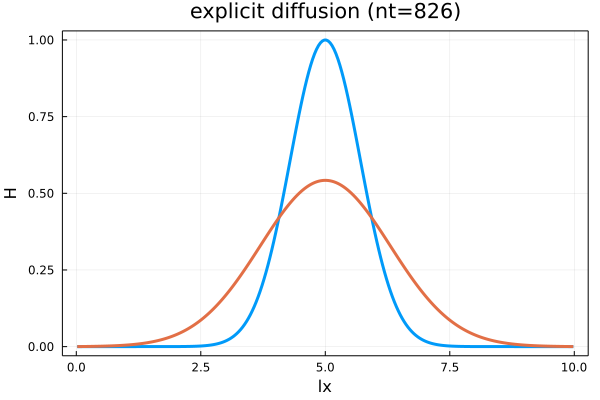

Total time = 0.60, time steps = 826, error vs analytic = 1.44e-03 


In [30]:
diffusion_1D_expl(; do_visu=do_visu);

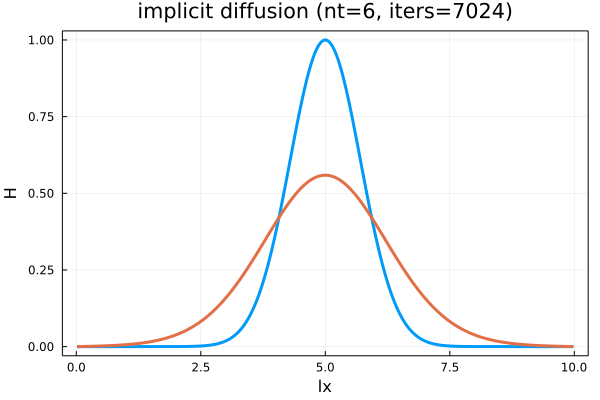

Total time = 0.60, time steps = 6, iterations tot = 7024, error vs analytic = 1.06e-01 


In [31]:
diffusion_1D_impl(; do_visu=do_visu);

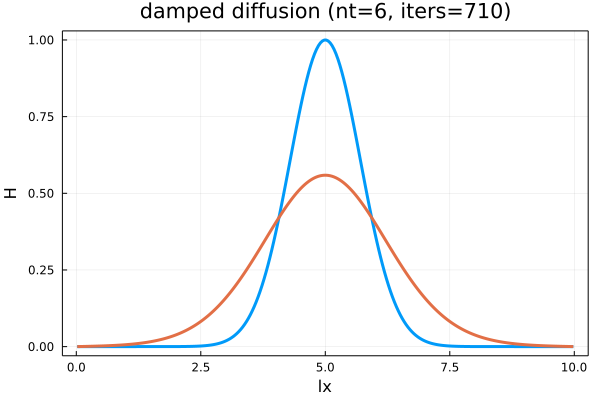

Total time = 0.60, time steps = 6, iterations tot = 710, error vs analytic = 1.06e-01 


In [32]:
diffusion_1D_damp(; do_visu=do_visu);